# 蠟燭線回測
### 初始資料拿取

In [3]:
import numpy as np
import pandas as pd
from talib import abstract
from finlab.data import Data

%matplotlib inline

data = Data()

signal = data.talib('CDLTRISTAR')

close = data.get_adj('收盤價')
open_ = data.get_adj('開盤價')

In [4]:
signal.unstack()[signal.unstack() != 0]

      date      
0015  2012-03-12   -100
      2012-05-21    100
      2012-11-01    100
0050  2012-11-19    100
      2015-04-01   -100
0051  2015-04-13    100
0052  2009-02-26   -100
      2009-12-10    100
      2010-04-21    100
      2010-07-30   -100
      2011-01-12    100
      2011-06-28    100
      2012-05-11    100
      2012-10-24   -100
      2013-09-18   -100
      2013-10-28   -100
      2013-12-17    100
      2014-05-12    100
      2014-12-10    100
      2014-12-11   -100
      2014-12-12    100
      2014-12-15   -100
      2016-01-30   -100
      2016-02-01    100
      2016-03-25    100
      2016-09-01   -100
      2016-09-02    100
      2016-10-12   -100
      2016-12-08    100
      2017-01-06   -100
                   ... 
9949  2013-10-11   -100
      2016-05-18   -100
      2016-11-10    100
      2018-03-05    100
      2018-08-08    100
      2019-01-23    100
9950  2008-09-03    100
      2013-10-28   -100
      2016-05-11   -100
      2016-12-29   -100

### 取得ETF股票資訊

In [5]:
# 看股票名稱，挑ETF股(005..開頭)
close.columns

Index(['0015', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057',
       '0058',
       ...
       '9944', '9945', '9946', '9949', '9950', '9951', '9955', '9958', '9960',
       '9962'],
      dtype='object', name='stock_id', length=1893)

In [6]:
sids = close.columns[1:11]

# only select wanted stock ids
signal = signal[sids]
close = close[sids]
open_ = open_[sids]

signal.head()

,0050,0051,0052,0053,0054,0055,0056,0057,0058,0059
date,,,,,,,,,,
2007-04-23,0,0,0,0,0,0,0,0,0,0
2007-04-24,0,0,0,0,0,0,0,0,0,0
2007-04-25,0,0,0,0,0,0,0,0,0,0
2007-04-26,0,0,0,0,0,0,0,0,0,0
2007-04-27,0,0,0,0,0,0,0,0,0,0


### 計算買入時間

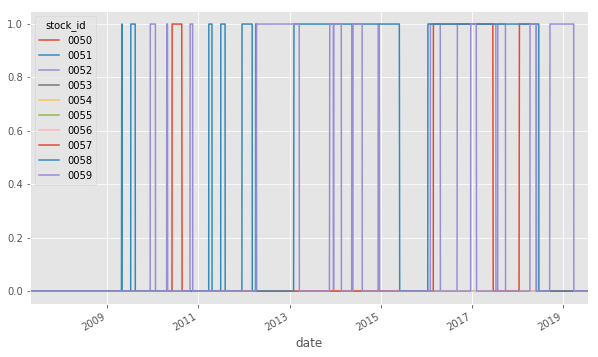

In [7]:
# 決定策略(買賣時間點)
buy = (signal > 0)  # 訊號出現就買
sell = close < close.rolling(20).mean()  # 股價小於最近20天的平均，賣出
    
# 持有的時間
hold = pd.DataFrame(np.nan, index=close.index, columns=close.columns)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)  # 針對每一條series
hold.fillna(0, inplace=True)
# 對hold做調整，因為candlestick pattern必須等收盤才能看到，發現訊號後隔天才能做買入的動作
# 因此往後推一格代表隔一天買入
hold = hold.shift()

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
hold.plot()

### 計算報酬率

#### 假設每天都rebalance(不合理)且不考慮手續費
假設有三檔股票，則每天都會把資產分三等份重下

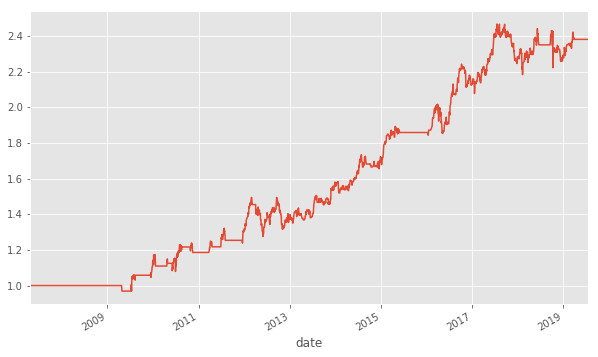

In [8]:
# Daily return
# 明天開盤價 除以 今天的開盤價
ret = open_.shift(-1) / open_
# 如果NaN，填入1代表不漲不跌
ret = ret.fillna(1)
# 只看持有部分
ret[hold != 1] = np.nan
ret.mean(axis=1).fillna(1).cumprod().plot() # 累積的績效表

# ret.mean(axis=1)[~np.isnan(ret.mean(axis=1).values)]

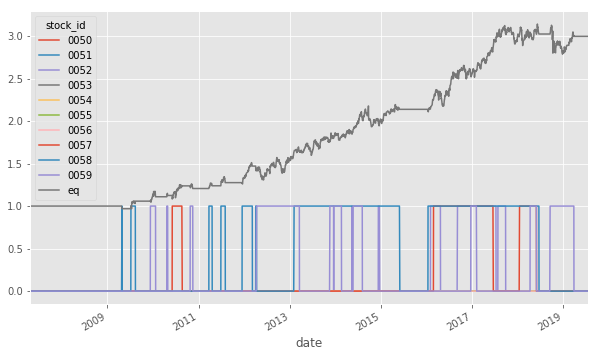

In [9]:
import matplotlib.pyplot as plt

# 明天的開盤價 除以 今天的開盤價 (用ffill是因為可能有NaN)
gain = open_.shift(-1).ffill()[sids] / open_.ffill()[sids]
eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()  # 看一下買賣策略的整體績效

# 
draw_df = hold.copy()
draw_df['eq'] = eq

draw_df.plot()

### 不要每天都rebalance (回測更精準)
當股票有增減的時候再去做權益平衡

#### 無考慮手續費的版本

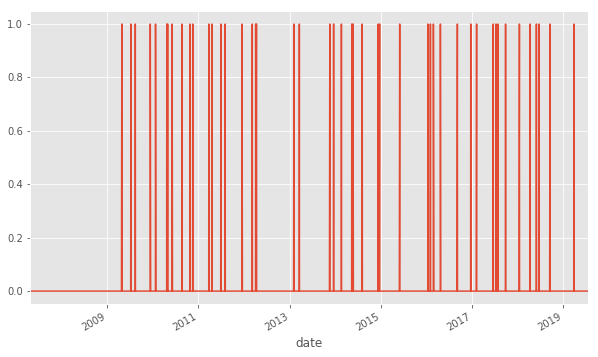

In [10]:
(hold.fillna(0).diff().abs().sum(axis=1) != 0).astype(int).plot() # 持有數量有發生變化的訊號

stock_id    0050  0051  0052  0053  0054  0055  0056  0057  0058  0059
date                                                                  
2007-04-23   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2009-04-27   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0
2009-04-28   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2009-07-08   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0
2009-08-13   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
stock_id        0050      0051      0052      0053      0054      0055  \
date                                                                     
2007-04-23  0.773114  0.668026  0.729829  0.615789  0.580870  0.580224   
2009-04-27  0.981481  0.972558  1.026942  0.970620  0.976471  0.959271   
2009-04-28  1.151447  1.223338  1.040590  1.128233  1.179305  1.319553   
2009-07-08  1.059646  1.050821  1.099291  1.100000  1.078125  0.957663   
2009-08-13  1.113519  1.067873  1.090323  1.124612  1.18115

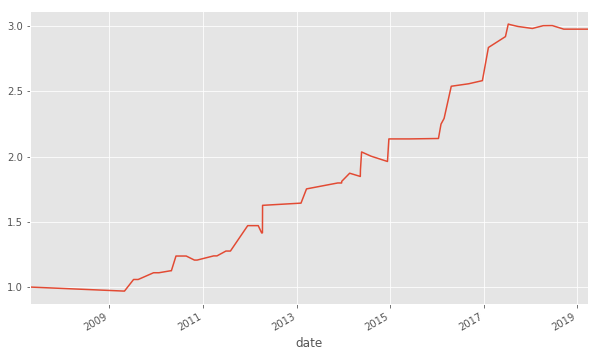

In [13]:
# Note: 股票清單有變化 != 每檔股票都持有

# 找出每個有增減股票的時間段
rebalance = (hold.fillna(0).diff().abs().sum(axis=1) != 0).cumsum()
rebalance_hold = hold[rebalance.diff() != 0] # 只取股票清單有變化的那一瞬間的列
print(rebalance_hold.head())
gain = open_.shift(-1).ffill()[sids] / open_.ffill()[sids]

# 每個時間段的累乘報酬
rebalance_gain = gain.groupby(rebalance.values).apply(lambda s: s.cumprod().iloc[-1])  # groupby每個時間段的累乘報酬，取最後一個
rebalance_gain.index = rebalance_hold.index  # index是hold的日期點
print(rebalance_gain.head())

rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1).cumprod().plot() # 只看有持有的股票報酬 整體績效(mean起來)

#### 有考慮手續費的版本
對股票的資產分配也考慮在內

In [29]:
print(rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).tail().fillna(0))
print(rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).tail().fillna(0).diff())
print(rebalance_hold.tail())

stock_id    0050  0051  0052  0053  0054  0055  0056      0057      0058  \
date                                                                       
2018-04-10   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.333333  0.333333   
2018-05-31   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  1.000000   
2018-06-20   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   
2018-09-17   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   
2019-03-27   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   

stock_id        0059  
date                  
2018-04-10  0.333333  
2018-05-31  0.000000  
2018-06-20  0.000000  
2018-09-17  1.000000  
2019-03-27  0.000000  
stock_id    0050  0051  0052  0053  0054  0055  0056      0057      0058  \
date                                                                       
2018-04-10   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN       NaN   
2018-05-31   0.0   0.0   0.0   0.0   0.0   0.0   0.0 -0.333333  0.666667   
20

In [42]:
rebalance_hold.tail().div(rebalance_hold.tail().sum(axis=1), axis=0)

stock_id,0050,0051,0052,0053,0054,0055,0056,0057,0058,0059
date,,,,,,,,,,
2018-04-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333
2018-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000
2018-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
2019-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2.585168974922036

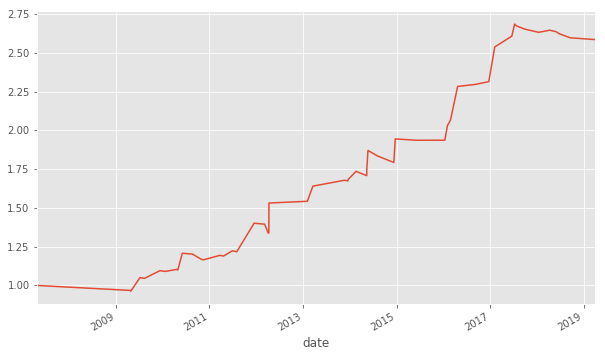

In [48]:
rebalance_signal = (hold.diff().abs().sum(axis=1) != 0).cumsum()  # 持有數量有發生變化的訊號，把它累加起來(沒變化就是一個時間段)
rebalance_hold = hold[rebalance_signal.diff() != 0]  # 找出持有數量前後有變化的時間點
rebalance_gain = gain.groupby(rebalance_signal.values).apply(lambda s:s.cumprod().iloc[-1])  # 每個時間段的累乘報酬，取最後一個
# 因為是用rebalance去groupby，所以index會留下第一個持有的日期
# 從持有到賣出第一個日期代表的就是這檔股票的報酬
rebalance_gain.index = rebalance_hold.index  # index是hold的日期點

# 手續費(對股票的資產分配也考慮在內)
# 下列等同於 rebalance_hold / rebalance_hold.sum(axis=1); 表中的數字代表的意義是"股票佔資產的比例"
# 找出有增減股票的訊號，分母為0的會自動變nan
position_diff = rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).fillna(0).diff() # 除上股票總數，代表資產分配情形 (3檔就每人分到0.33)
tax_ratio = position_diff.copy()
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)  # 賣出(對每檔股票with資產分配比例)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
# 把這些ratio by 欄 sum起來當作整體績效
tax_ratio = tax_ratio.abs().sum(axis=1)

# (1 - tax_ratio) --> cost of transactions
# 一樣，算gain(報酬)的時候都是每檔都算，但持不持有是另一回事~下列就是只算有持有的話累積報酬是多少
eq2 = (rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1) * (1 - tax_ratio)).cumprod()  # 只算有持有的
eq2.plot()
eq2.iloc[-1]

## 考慮手續費

In [49]:
history = {
    'ret':eq,
    'position':hold == 1,
}

import pickle
pickle.dump(history, open('20200202_考慮手續費的蠟燭線回測績效.pkl', 'wb'))

In [50]:
history

{'ret': date
 2007-04-23    1.000000
 2007-04-24    1.000000
 2007-04-25    1.000000
 2007-04-26    1.000000
 2007-04-27    1.000000
 2007-04-30    1.000000
 2007-05-02    1.000000
 2007-05-03    1.000000
 2007-05-04    1.000000
 2007-05-07    1.000000
 2007-05-08    1.000000
 2007-05-09    1.000000
 2007-05-10    1.000000
 2007-05-11    1.000000
 2007-05-14    1.000000
 2007-05-15    1.000000
 2007-05-16    1.000000
 2007-05-17    1.000000
 2007-05-18    1.000000
 2007-05-21    1.000000
 2007-05-22    1.000000
 2007-05-23    1.000000
 2007-05-24    1.000000
 2007-05-25    1.000000
 2007-05-28    1.000000
 2007-05-29    1.000000
 2007-05-30    1.000000
 2007-05-31    1.000000
 2007-06-01    1.000000
 2007-06-04    1.000000
                 ...   
 2019-06-10    2.996423
 2019-06-11    2.996423
 2019-06-12    2.996423
 2019-06-13    2.996423
 2019-06-14    2.996423
 2019-06-17    2.996423
 2019-06-18    2.996423
 2019-06-19    2.996423
 2019-06-20    2.996423
 2019-06-21    2.996423
 20